In [1]:
## Preamble: Package Loading
import numpy as np
import ipywidgets as ipw
from IPython.display import display,display_html
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import json
import kernel as kr
import psc_dbl_sumdisp as psd 

In [2]:
%%html
<style>
#.cell.selected~.unselected { display: none; }
#.cell.code_cell.unselected .input { display: none; }
</style>

<h1> Selection of Heterogenous Instruments in Partially Linear Fixed Effect Panel Regression </h1>

<h2> Monte Carlo Study Results </h2>

**By: Eric Penner **

<h2> Summary </h2>

The following notebook contains results of a Monte Carlo Exercise conducted on the estimator detailed in 'shi.ipynb' and 'shi_wp.pdf' with a data sets generated by 'shi_dgp.ipnyb' (see this notebook for details of the DGP). 

Important features of each of the following trials are presented here

* All estimates have been generated with the knowledge that the secondary equations are panel type (i.e. the estimation of the secondary equations is properly specified). 


* The number of datasets used from each component of each trial is 'nds = 500'

In [3]:
# Trial 1.1: 0
inpt_filenames=[['pscout_9_4_1347.json' ,'pscout_9_4_1505.json' ,'pscout_9_4_1913.json' ,'pscout_9_4_1816.json']]
line_nms=[['Oracle','Known','Unknown','Lasso']]

#Trial 1.2: 1
inpt_filenames.append(['pscout_9_4_1232.json' ,'pscout_9_4_1837.json','pscout_9_4_1969.json' ,'pscout_9_4_1655.json' ])
line_nms.append(['Oracle','Known','Unknown','Lasso'])

#Trial 1.3: 2
inpt_filenames.append(['pscout_9_4_1636.json','pscout_9_4_1191.json','pscout_9_4_1510.json'])
line_nms.append(['Oracle','Known','Lasso'])

#Trial 1.4: 3
inpt_filenames.append(['pscout_9_4_1816.json','pscout_9_4_1655.json','pscout_9_4_1510.json','pscout_9_5_1624.json'])
line_nms.append(['t_inst=15','t_inst=30','t_inst=45','t_inst=100'])

#Trial 2.0: 4
inpt_filenames.append(['pscout_9_5_1624.json','pscout_9_6_1331.json','pscout_9_6_1606.json'])
line_nms.append(['ncs = 10','ncs = 25','ncs = 40'])

#Trial 3.0: 5
inpt_filenames.append(['pscout_9_5_1624.json','pscout_9_6_1537.json','pscout_9_6_1725.json'])
line_nms.append(['ntp = 50','ntp = 100','ntp = 150'])

In [4]:
res_out = [[psd.psc_load(inpt_filenames[k][i]) for i in range(len(inpt_filenames[k]))] 
                                               for k in range(len(line_nms))]

estin_dcts = [[res_out[k][i][0] for i in range(len(inpt_filenames[k]))]
                                for k in range(len(line_nms))]

dgp_sum_filenames = [[estin_dcts[k][i]['input_filename'].replace('pscdata','pscsum')
                                for i in range(len(inpt_filenames[k]))]
                                for k in range(len(line_nms))]
    
dgp_dicts = [[psd.pscsum_load(dgp_sum_filenames[k][i]) 
                                for i in range(len(dgp_sum_filenames[k]))]
                                for k in range(len(line_nms))]

dgpin_dcts =  [[dgp_dicts[k][i][0] for i in range(len(inpt_filenames[k]))]
                                   for k in range(len(line_nms))]

merged_dcts = [[{**estin_dcts[k][i],**dgpin_dcts[k][i]} 
                                   for i in range(len(inpt_filenames[k]))]
                                   for k in range(len(line_nms))]

true_bcoeffs = [[dgp_dicts[k][i][1] for i in range(len(inpt_filenames[k]))]
                                    for k in range(len(line_nms))]

true_acoeffs = [[dgp_dicts[k][i][2] for i in range(len(inpt_filenames[k]))]
                                    for k in range(len(line_nms))]

bcoeff  = [[res_out[k][i][1] for i in range(len(inpt_filenames[k]))]
                             for k in range(len(line_nms))]

acoeff  = [[res_out[k][i][3] for i in range(len(inpt_filenames[k]))]
                             for k in range(len(line_nms))]

btables = [[res_out[k][i][2] for i in range(len(inpt_filenames[k]))]
                             for k in range(len(line_nms))]

atables = [[res_out[k][i][4] for i in range(len(inpt_filenames[k]))]
                             for k in range(len(line_nms))]

<a id='index'><a>

<h2> Index </h2>
<ul>
    <li> <a href='#dgp'>Data Generating Process</a> <br>
        <br>
    <li> <a href='#var_desc'>Variable Description</a> <br>
        <br>
    <li> <a href='#trial_1'> Trial Set 1:  Estimator comparison varying the total number of instruments</a> <br>
        <br>
    <ul> 
        <li> <a href='#trial_11'> Trial Set 1.1:  Estimator Comparison when $t_{inst} = 15$ </a> <br>
        <br>
        <li> <a href='#trial_12'> Trial Set 1.2:  Estimator Comparison when $t_{inst} = 30$ </a> <br>
        <br>
        <li> <a href='#trial_13'> Trial Set 1.3:  Estimator Comparison when $t_{inst} = 45$ </a> <br>
        <br>
        <li> <a href='#trial_14'> Trial Set 1.4:   Lasso Comparison where $t_{inst} \in \{15,30,45,100\}$ </a> <br>
        <br>
    </ul> 
     <li> <a href='#trial_2'> Trial Set 2.0: Properties of Lasso Estimator, Increasing Number of Cross Sections </a> <br>
       <br>
     <li> <a href='#trial_3'> Trial Set 3.0: Properties of Lasso Estimator, Increasing Number of Time Periods </a> <br>
       <br>
</ul>


<a id='dgp'></a>
<h2> Data Generating Process </h2>

Here I describe the process by which the data for the Monte Carlo Exercise was generated. 

<h3> DGP: Base Model </h3>

For each time period $t \in \{1,2, \ldots, T\}$, component $ d\in \{1,2, \ldots , p_1\}$ of $Z_{1jt}$, and cross-section $j \in \{1,2,\ldots, q\}$ where $\{q,T\} \in \mathbb{N}$ consider the following,

\begin{align} 
Y_{jt} &= \beta_0 + [\; Z_{1jt}' \;\; Z_{2jt}' \;] \beta_1 + e_j + \varepsilon_{jt} \\[1em]
%
Z_{1jt,d} &= \alpha_{0jd} + Z_{2jt}' \alpha_{1jd} + W_{jt}' \alpha_{2jd} + V_{jt,d} \tag{2d} \\[1em]
%
E(&\varepsilon_{jt} | Z_{1jt} , Z_{2jt}) = E(\varepsilon_{jt} | Z_{1jt}) \neq 0  \\[1em]
%
E(& V_{jdt} | Z_{1j(t-1)},\ldots,Z_{1j(t-c)},Z_{2jt},W_{jt}) = 0 
%
\end{align}


<h3> DGP: Error, Instrument, and Exogenous Variable Generation </h3>

Let; $n_{tp} \equiv T$ be the total number of time periods, $n_{end} \equiv p_1$ be the number of endogneous regressors included in the primary regression, $n_{exo} \equiv p_2$ be the number of exogenous regressors included in the primary regression, and $n_{tinst} \equiv w$, $ n_{cinst} \equiv w_j$ be the total number of available instruments and the number of instruments relevant to each crossection respectively. Now let,

$$
\begin{align*} 
\rho_{er} &= \begin{bmatrix} \rho_{er,1} & \rho_{er,2} & \cdots & \rho_{er,n_{end}} \end{bmatrix} \\
\rho_{inst} &= \begin{bmatrix} \rho_{inst,1} & \rho_{inst,2} & \cdots & \rho_{inst,n_{inst}-1} \end{bmatrix}\\
\rho_{ex} &= \begin{bmatrix} \rho_{ex,1} & \rho_{ex,2} & \cdots & \rho_{ex,n_{ex}-1} \end{bmatrix}  
\end{align*}
$$

So that I can define the covariance matrices for *each* cross section as follows 

$$
\begin{align*}
cv_{er} &= \begin{bmatrix} 
1 & \rho_{er,1} & \rho_{er,2} & \cdots & \rho_{er,n_{end}} \\
\rho_{er,1} & 1  & \rho_{er,1} &\cdots & \rho_{er,n_{end}-1} \\
\rho_{er,2} & \rho_{er,1} & 1 & \cdots & \rho_{er,n_{end}-2} \\
\vdots & &&\ddots&  \\
 \rho_{er,n_{end}} & \rho_{er,n_{end}-1} & \rho_{er,n_{end}-2} & \cdots &  1 
\end{bmatrix}
%
\hspace{1cm} 
%
%
cv_{ex} &= \begin{bmatrix} 
1 & \rho_{ex,1} & \rho_{ex,2} & \cdots & \rho_{ex,n_{ex}-1} \\
\rho_{ex,1} & 1  & \rho_{ex,1} &\cdots & \rho_{ex,n_{ex}-2} \\
\rho_{ex,2} & \rho_{ex,1} & 1 & \cdots & \rho_{ex,n_{ex}-3} \\
\vdots & &&\ddots&  \\
 \rho_{ex,n_{ex}-1} & \rho_{ex,n_{ex}-2} & \rho_{ex,n_{ex}-2} & \cdots &  1 
\end{bmatrix}
\end{align*} 
$$

Since all crossections will use some subset of the vector of instruments the following is the full covariance matrix for all instruments.

$$
CV_{inst} = \begin{bmatrix} 
1 & \rho_{inst,1} & \rho_{inst,2} & \cdots & \rho_{inst,n_{tinst}-1} \\
\rho_{inst,1} & 1  & \rho_{inst,1} &\cdots & \rho_{inst,n_{tinst}-2} \\
\rho_{inst,2} & \rho_{tinst,1} & 1 & \cdots & \rho_{inst,n_{tinst}-3} \\
\vdots & &&\ddots&  \\
 \rho_{inst,n_{tinst}-1} & \rho_{inst,n_{tinst}-2} & \rho_{inst,n_{tinst}-3} & \cdots &  1 
\end{bmatrix}
%
$$

As a result we can construct the covariance matrices for all cross sections,

$$
\begin{align*}
CV_{er} &= 
\begin{bmatrix}
cv_{er} & \mathbf{0}_{(n_{end}+1 \times n_{end}+1)} & \cdots & \mathbf{0}_{(n_{end}+1 \times n_{end}+1)}  \\
\mathbf{0}_{(n_{end}+1 \times n_{end}+1)} & cv_{er} & \cdots & \mathbf{0}_{(n_{end}+1 \times n_{end}+1)}  \\
\vdots & \vdots & \ddots & \vdots \\
\mathbf{0}_{(n_{end}+1 \times n_{end}+1)} & \mathbf{0}_{(n_{end}+1 \times n_{end}+1)} & \cdots & cv_{er}
\end{bmatrix} 
%
\hspace{1cm}
%
CV_{ex}  = 
\begin{bmatrix}
cv_{ex} & \mathbf{0}_{(n_{ex} \times n_{ex})} & \cdots & \mathbf{0}_{(n_{ex} \times n_{ex})}  \\
\mathbf{0}_{(n_{ex} \times n_{ex})} & cv_{ex} & \cdots & \mathbf{0}_{(n_{ex} \times n_{ex})}  \\
\vdots & \vdots & \ddots & \vdots \\
\mathbf{0}_{(n_{ex} \times n_{ex})} & \mathbf{0}_{(n_{ex} \times n_{ex})} & \cdots & cv_{ex}
\end{bmatrix} 
\end{align*}
$$


Now I generate, error terms, instruments, and exogneous variables from mulitvariate normal distribution. First let

$$ 
\begin{align*} 
Z_{2jt} &= \begin{bmatrix} Z_{2jt,1} & Z_{2jt,2} & \cdots & Z_{2jt,n_{ex}} \end{bmatrix}' \\[10pt]  
W_t &= \begin{bmatrix} W_{t,1} & W_{t,2} & \cdots & W_{t,n_{inst}} \end{bmatrix}' \\[10pt]
\tilde{V}_{jt} &= \begin{bmatrix} V_{jt,1} & V_{jt,2}& \cdots & V_{jt,n_{end}} & \varepsilon_{j} \end{bmatrix}' 
\end{align*} 
$$

Then consider, $ W_{t} \sim N(\mathbf{0}_{n_{inst} \times 1}, CV_{inst})$

$$
\begin{bmatrix} Z_{21t}' & Z_{22t}' & \cdots & Z_{2n_{cs}t}' \end{bmatrix}' \sim N(\mathbf{0}_{n_{cs} \cdot n_{exo} \times 1}, CV_{ex})
\hspace{1cm} \text{ and } \hspace{1cm} 
\begin{bmatrix} \tilde{V}_{1t}' & \tilde{V}_{2t}' & \cdots & \tilde{V}_{n_{cs},t}' \end{bmatrix}' \sim N(\mathbf{0}_{n_{cs} \cdot (n_{end} +1) \times 1}, CV_{er})
$$

<h3> DGP: Endogenous Variable Generation:</h3>

I will generate endogenous variables $ Z_{1jd} $ according to the following steps.

* For each $d \in \{1,2,\cdots,n_{end} \}$ I will draw the coefficienct vector $\alpha_{1d}$ from the cartesian product of $[1,1]$ with itself $n_{exo}$ times. 


* For each $j\in \{1,2,\cdots , n_{cs}\}$ I will draw a sequence of integers $C_{j}$ from the $\mathcal{C}^{n_{tinst}}_{n_{cinst}}$ ways that that you can choose $n_{cinst}$ instruments from $n_{tinst}$ total instrument to be included in every regression of $Z_{1j}$ on $Z_{2j}$ and $W$ i.e. these numbers define which columns of $W$ are included in $W_j$.


* For each $d \in \{1,2,\cdots,n_{end} \}$ I will draw the coefficienct vector $\alpha_{2d}$ from the cartesian product of $[1,1]$ with itself $n_{tinst}$ times. 


* Then for each $j\in \{1,2,\cdots , n_{cs}\}$ and $d \in \{1,2,\cdots,n_{end} \}$ I generate endogenous regressors $Z_{1jd}$ as follows

$$ Z_{1jd} =  \alpha_{0jd} + Z_{2jt}' \alpha_{1d} + W_{jt}' \alpha_{2d} + V_{jt,d} \hspace{1cm} \text{ where } \hspace{1cm} \alpha_{0jd} = 1/2+j/2 $$ 


<h3> DGP: Primary Regressand Generation </h3>

Having generated all primary regressors I will generate the regresand for the primary equation to do this I will,

* I will draw the coefficienct vector $\beta_1$ from the cartesian product of $[1,1]$ with itself $n_{exo} +n_{end}$ times. Then set


$$ Y_{jt} = [\; Z_{1jt}' \;\; Z_{2jt}' \;] \beta_1 + e_j + \varepsilon_{jt} \;\;\;\; \text{ where } \;\;\;\;  e_{j} = 1+j/2  $$



<a href='#index'> Back to Index </a>
<a id='var_desc'></a>

<h3> Variable Description Table </h3>

A number of variables are used below, here are their descriptions. Refer back to 'psc.ipynb' or 'psc_dgp.ipynb' for more details.

Variable Name  |  Description  
--|--
k_H| Kernel number used for H function Estimation  
c_H |  Plug in bandwidth constant for H function Estimation
k_mvd  | Kernel number used for multivariate d>2 density estimation
c_mvd|  Plug in bandwidth constant for multivariate d>2 density estimation
k_uvd  |  Kernel number used for bivariate density  estimation 
c_uvd |  Plug in bandwidth used for bivariate density estimation
dep_nm|  Variable name of the dependent variable
en_nm |  Variable names of each endogenous variabble
ex_nm |  Variable names of each exogenous variable
in_nm |  Variable names of instruments relevant to each cross section
err_vpro|  Vector of covariances used to construct the error cov matrix
ex_vpro|  Vector of covariances used to construct the exog variable cov matrix
inst_vpro | Vector of covariances used to construct the instrument cov matrix
frc |  Indicator for whether the functional form of control function is forced
input_filename|  Filename of dataset used to generate the results. 
kwnsub  | Indicator for ifthe subset of instrument relevant to each crs is known
n_end  |  Number of endogenous variables 
n_exo|  Number of exogenous variables
ncs  |  Number cross sections
nds  |  Number of dgp data sets
ntp |  Number of time periods
orcl |  Indicator for whether residuals $V$ are observed (=1) or not
r_seed|  Random number generator seed used to generate the data set
sec_pan|  Indicator for whether the secondary eqn data is panel or not
c_inst  |  Number of instrument relevant to each cross section   
t_inst|  Total number of instruments
inc | List of instrument relevant to at least one cross section
tin  |  Variable name of the time period index
cin  |  Variable name of the cross section index 
lasso | Indicator for lasso estimation
alph | lasso penalty value
epsil | Threshold for averaging "non zero" coefficients

<a href='#index'> Back to Index </a>
<a id='trial_1'><a>

<h1> Trial Set 1: Estimator comparison by varying the total number of instruments </h1>

<a href='#index'> Back to Index </a>
<a id='trial_11'></a>

<h2> Trial Set 1.1: Estimator Comparison when $t_{inst} = 15$ </h2> 

Here we examine the sampling distribution of $\hat{\beta}_1$, and $ \hat{\alpha}_{1} $.

* Number of Cross Sections: 10


* Number of Endogenous Regressors: 1


* Number of Exogenous Regressors: 1


* Total Number of Instruments: 15


* Number of Instrument Relevant to Each Cross Section: 3


<h3> Trial Set 1.1: Merged DGP and Estimator Function Input Dictionary Comparison </h3> 

Here I have merged together the dictionaries used to generate both the underlying dataset and the results (you will see the file name for this data set below) and the dictionary used to produce the estimates based on that data below. For a description of each variable name please see <a href='#var_desc'>Variable Description</a>

In [5]:
merged_dcts[0][0]

{'alph': 0.4,
 'c_H': 1.0,
 'c_inst': 3,
 'c_mvd': 1.0,
 'c_uvd': 1.0,
 'cin': 'crs',
 'cv': 0,
 'dep_nm': 'Y',
 'en_nm': ['Z1,1'],
 'epsil': 0.1,
 'err_vpro': [0.8, 0.36],
 'ex_nm': ['Z2,1'],
 'ex_vpro': [0.5],
 'frc': 0,
 'input_filename': 'pscdata_9_4_1129.json',
 'inst_vpro': [0.5, 0.25, -0.1],
 'k_H': 9,
 'k_mvd': 9,
 'k_parts': 4,
 'k_uvd': 9,
 'kwnsub': 1,
 'lasso': 0,
 'n_alphs': 20,
 'n_end': 1,
 'n_exo': 1,
 'n_parts': 4,
 'ncs': 10,
 'nds': 500,
 'ntp': 50,
 'orcl': 1,
 'r_seed': 19977,
 'sec_pan': 1,
 't_inst': 15,
 'tin': 't'}

<h3> Trial Set 1.1: True Secondary Equation Coefficients Comparison </h3> 

Here I display the coefficent vectors $\alpha_{1jd}$ used to generate the data set (by row indicating cross section and equation) corresponding to the position its file name appears in 'input_filenames0' above.

**Note:** 


1.) A zero coefficient in the following matrix means that the instrument it multiplies is not relevant to that cross section. 

2.) The density of the secondary regression coefficient matrix is **25%**


In [6]:
display_html(true_acoeffs[0][0][0])

,"$\alpha_{11,1}$","$\alpha_{12,1}$","$\alpha_{12,2}$","$\alpha_{12,3}$","$\alpha_{12,4}$","$\alpha_{12,5}$","$\alpha_{12,6}$","$\alpha_{12,7}$","$\alpha_{12,8}$","$\alpha_{12,9}$","$\alpha_{12,10}$","$\alpha_{12,11}$","$\alpha_{12,12}$","$\alpha_{12,13}$","$\alpha_{12,14}$","$\alpha_{12,15}$"
0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,0.0,0.0
7,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,1.0,0.0
9,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> Trial Set 1.1: Secondary Function Coefficient Estimates </h3>

Here I show characteristics of the sampling distributions of the elements of $\hat{\alpha}_{dj}$.

In [7]:
for i in range(1,len(atables[0])):
    display(atables[0][i][0])
    display(line_nms[0][i])

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$","$\hat{\alpha}_{12,10}$","$\hat{\alpha}_{12,11}$","$\hat{\alpha}_{12,12}$","$\hat{\alpha}_{12,13}$","$\hat{\alpha}_{12,14}$","$\hat{\alpha}_{12,15}$"
Bias,-0.006140,-0.002809,-0.005234,0.001447,-0.004661,0.007054,0.001279,-0.004996,0.005133,-0.006316,-0.006574,0.002447,-0.001375,0.011662,-0.002119,0.0
Std,0.051223,0.105168,0.120078,0.171301,0.104453,0.175589,0.170414,0.102692,0.102423,0.099613,0.129481,0.126472,0.103982,0.185779,0.119445,0.0
MSE,0.002661,0.011068,0.014446,0.029346,0.010932,0.030881,0.029042,0.010571,0.010517,0.009963,0.016809,0.016001,0.010814,0.034650,0.014272,0.0


'Known'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$","$\hat{\alpha}_{12,10}$","$\hat{\alpha}_{12,11}$","$\hat{\alpha}_{12,12}$","$\hat{\alpha}_{12,13}$","$\hat{\alpha}_{12,14}$","$\hat{\alpha}_{12,15}$"
Bias,-0.007172,-0.702113,0.791730,-0.895291,0.696390,0.902167,0.900801,0.699474,0.701084,-0.705203,-0.802940,0.808000,0.699564,0.898726,-0.798882,0.000130
Std,0.092144,0.085474,0.098581,0.100936,0.109096,0.107946,0.113176,0.120130,0.117885,0.117305,0.119668,0.108577,0.109132,0.103006,0.100870,0.081149
MSE,0.008542,0.500268,0.636554,0.811735,0.496861,0.825558,0.824250,0.503695,0.505416,0.511071,0.659033,0.664653,0.501300,0.818318,0.648387,0.006585


'Unknown'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$","$\hat{\alpha}_{12,10}$","$\hat{\alpha}_{12,11}$","$\hat{\alpha}_{12,12}$","$\hat{\alpha}_{12,13}$","$\hat{\alpha}_{12,14}$","$\hat{\alpha}_{12,15}$"
Bias,-0.005541,-0.446483,0.534845,-0.675079,0.379093,0.525860,0.560702,0.401696,0.508020,-0.517522,-0.622378,0.610824,0.428099,0.437460,-0.513449,0.076449
Std,0.064865,0.132366,0.161115,0.217579,0.133220,0.201003,0.145007,0.129059,0.134231,0.135563,0.152786,0.145446,0.118378,0.222665,0.153408,0.116722
MSE,0.004238,0.216868,0.312017,0.503072,0.161459,0.316931,0.335414,0.178016,0.276102,0.286206,0.410698,0.394260,0.197282,0.240951,0.287163,0.019468


'Lasso'

<h3> Trial Set 1.1: Comments on Secondary Function Coefficient Estimates </h3>
    
<ul> 
       <li> Here you can see that, as we would expect, the known subset estimator generates unbiased estimators, the unknown subset estimator generates badly biased estimates, and the lasso estimator generates estimates whose bias roughly splits that difference between the previous two.
       <br>   
       <li> Note that the properties of the lasso estimator are what you would expect from a consistent estimator, where the variance of the sampling distribution of each coefficient in inversely proportional to the number of crossections that the instrument it multiplies is relevant to. <br>
       <br>
       <li> This presentation is really only a frame of reference as the sampling distribution of the estimates isn't of first order importance in this estimator. 
</ul>


<h3> Trial Set 1.1: True Primary Equations Coefficients Comparison </h3>

Here I display the coefficent vector $\beta_1$ used to generate the data set corresponding to the position its file name appears in 'input_filenames0' above.

In [8]:
true_bcoeffs[0][0]

,"$\beta_{1,1}$","$\beta_{1,2}$"
0,1,-1


<h3> Trial Set 1.1: Primary Function Coefficient Estimates </h3>

Here I show the sampling distribution of the elements of $\hat{\beta}_1$.  

In [9]:
psd.tbl_dsp(btables[0],1,5,line_nms[0],1)

,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.145153,-0.148425
Std,0.046727,0.081102
MSE,0.023253,0.028607
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.159544,-0.161931
Std,0.047712,0.095164
MSE,0.027731,0.035278
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.187178,-0.188395
Std,0.041588,0.072844


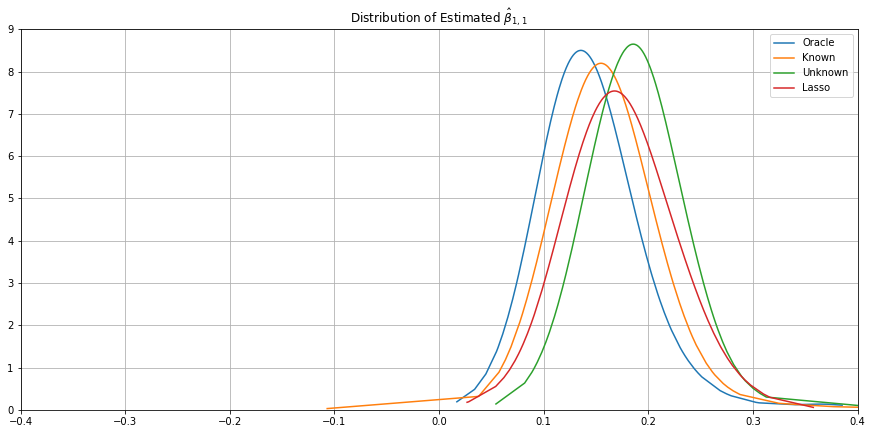

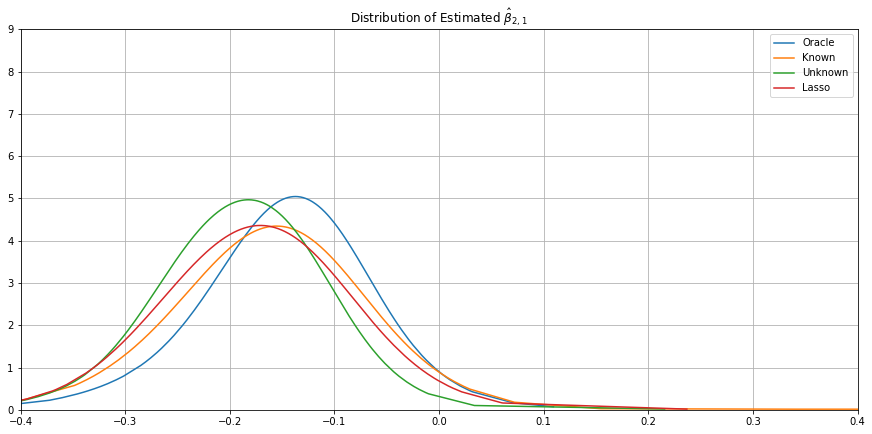

In [10]:
psd.coeffden(bcoeff[0],line_nms[0],[-0.4,0.4],9,2,1,0,0)
psd.coeffden(bcoeff[0],line_nms[0],[-0.4,0.4],9,2,0,0,0)

<h3> Trial Set 1.1: Comments on Primary Function Coefficient Estimates </h3>

<ul> 
    <li> Oracle is clearly the best estimator, followed by the known subset, lasso estimator, and unknown subset estimator. In both cases the bias of the lasso estimator more or less splits the difference between the the known and unknown estimator.  <br> 
</ul>

<a href='#index'> Back to Index </a>
<a id='trial_12'></a>

<h2> Trial Set 1.2: Estimator Comparison when $t_{inst} = 30$ </h2> 

Here we examine the sampling distribution of $\hat{\beta}_1, \hat{\alpha}_{1}$


<ul> 
    <li> Number of Cross Sections: 10 <br> <br>
    <li> Number of Time Periods: 50 <br> <br>
    <li> Number of Endogenous Regressors: 1    <br><br>
    <li> Number of Exogenous Regressors: 1    <br><br>
    <li> Total Number of Instruments: 30    <br><br>
    <li> Number of Instrument Relevant to Each Cross Section: 3    <br><br>
<ul>




<h3> Trial Set 1.2: Merged DGP and Estimator Function Input Dictionary Comparison </h3> 

Here I have merged together the dictionaries used to generate both the underlying dataset and the results (you will see the file name for this data set below) and the dictionary used to produce the estimates based on that data below. For a description of each variable name please see <a href='#var_desc'>Variable Description</a>

In [11]:
merged_dcts[1][0]

{'alph': 0.4,
 'c_H': 1.0,
 'c_inst': 3,
 'c_mvd': 1.0,
 'c_uvd': 1.0,
 'cin': 'crs',
 'cv': 0,
 'dep_nm': 'Y',
 'en_nm': ['Z1,1'],
 'epsil': 0.1,
 'err_vpro': [0.8, 0.36],
 'ex_nm': ['Z2,1'],
 'ex_vpro': [0.5],
 'frc': 0,
 'input_filename': 'pscdata_9_4_1405.json',
 'inst_vpro': [0.5, 0.25, -0.1],
 'k_H': 9,
 'k_mvd': 9,
 'k_parts': 4,
 'k_uvd': 9,
 'kwnsub': 1,
 'lasso': 0,
 'n_alphs': 20,
 'n_end': 1,
 'n_exo': 1,
 'n_parts': 4,
 'ncs': 10,
 'nds': 500,
 'ntp': 50,
 'orcl': 1,
 'r_seed': 19977,
 'sec_pan': 1,
 't_inst': 30,
 'tin': 't'}

<h3> Trial Set 1.2: True Secondary Equation Coefficients Comparison </h3> 

Here I display the coefficent vectors $\alpha_{1jd}$ used to generate the data set (by row indicating cross section and equation) corresponding to the position its file name appears in 'input_filenames0' above.

**Note:** 


1.) The density of the secondary regression coefficient matrix is **13%**


In [12]:
display_html(true_acoeffs[1][0][0])

,"$\alpha_{11,1}$","$\alpha_{12,1}$","$\alpha_{12,2}$","$\alpha_{12,3}$","$\alpha_{12,4}$","$\alpha_{12,5}$","$\alpha_{12,6}$","$\alpha_{12,7}$","$\alpha_{12,8}$","$\alpha_{12,9}$",...,"$\alpha_{12,21}$","$\alpha_{12,22}$","$\alpha_{12,23}$","$\alpha_{12,24}$","$\alpha_{12,25}$","$\alpha_{12,26}$","$\alpha_{12,27}$","$\alpha_{12,28}$","$\alpha_{12,29}$","$\alpha_{12,30}$"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,1.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<h3> Trial Set 1.2: Secondary Function Coefficient Estimates </h3>

Here I show characteristics of the sampling distributions of the elements of $\hat{\alpha}_{dj}$. 

In [13]:
for i in range(1,len(atables[1])):
    display(atables[1][i][0])
    display(line_nms[1][i])

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,21}$","$\hat{\alpha}_{12,22}$","$\hat{\alpha}_{12,23}$","$\hat{\alpha}_{12,24}$","$\hat{\alpha}_{12,25}$","$\hat{\alpha}_{12,26}$","$\hat{\alpha}_{12,27}$","$\hat{\alpha}_{12,28}$","$\hat{\alpha}_{12,29}$","$\hat{\alpha}_{12,30}$"
Bias,0.001473,0.0,-0.001355,-0.001342,0.0,0.006849,-0.005371,0.003639,0.000277,0.000881,...,0.0,-0.000837,0.0,-0.007544,0.000658,-0.011681,-0.003333,0.002229,0.005794,0.0
Std,0.050771,0.0,0.181220,0.128354,0.0,0.119046,0.120226,0.106579,0.116267,0.169879,...,0.0,0.174405,0.0,0.168704,0.098665,0.162550,0.157367,0.169609,0.113742,0.0
MSE,0.002580,0.0,0.032842,0.016477,0.0,0.014219,0.014483,0.011372,0.013518,0.028860,...,0.0,0.030418,0.0,0.028518,0.009735,0.026559,0.024776,0.028772,0.012971,0.0


'Known'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,21}$","$\hat{\alpha}_{12,22}$","$\hat{\alpha}_{12,23}$","$\hat{\alpha}_{12,24}$","$\hat{\alpha}_{12,25}$","$\hat{\alpha}_{12,26}$","$\hat{\alpha}_{12,27}$","$\hat{\alpha}_{12,28}$","$\hat{\alpha}_{12,29}$","$\hat{\alpha}_{12,30}$"
Bias,0.013180,0.004105,0.893524,-0.804328,0.005225,0.805619,0.796211,0.699444,0.795501,-0.886311,...,0.004841,0.897182,0.004343,0.899901,0.687036,-0.890799,-0.901919,-0.908279,-0.796826,0.004967
Std,0.098132,0.144856,0.169268,0.171906,0.189469,0.186838,0.200096,0.193893,0.194956,0.195231,...,0.205551,0.204955,0.202955,0.199917,0.198581,0.195874,0.186840,0.161797,0.166022,0.137942
MSE,0.009804,0.021000,0.827037,0.676495,0.035926,0.683931,0.673989,0.526817,0.670830,0.823662,...,0.042275,0.846942,0.041210,0.849788,0.511452,0.831888,0.848366,0.851148,0.662495,0.019053


'Unknown'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,21}$","$\hat{\alpha}_{12,22}$","$\hat{\alpha}_{12,23}$","$\hat{\alpha}_{12,24}$","$\hat{\alpha}_{12,25}$","$\hat{\alpha}_{12,26}$","$\hat{\alpha}_{12,27}$","$\hat{\alpha}_{12,28}$","$\hat{\alpha}_{12,29}$","$\hat{\alpha}_{12,30}$"
Bias,-0.006703,-0.008311,0.774174,-0.555108,-0.012742,0.531917,0.477534,0.422525,0.431064,-0.689710,...,-0.000667,0.563147,-0.078744,0.553700,0.450432,-0.644967,-0.570113,-0.533112,-0.476856,0.046149
Std,0.118067,0.113632,0.192091,0.151288,0.131367,0.148253,0.113703,0.112409,0.135524,0.192073,...,0.110977,0.199392,0.108498,0.168895,0.126237,0.198442,0.177251,0.169420,0.136242,0.114348
MSE,0.013985,0.012981,0.636245,0.331033,0.017420,0.304914,0.240967,0.191163,0.204183,0.512592,...,0.012316,0.356891,0.017973,0.335110,0.218824,0.455362,0.356446,0.312911,0.245953,0.015205


'Lasso'

<h3> Trial Set 1.2: Comments on Secondary Function Coefficient Estimates </h3>
    
<ul>
       <li> Same comments roughly as 1.1 
</ul>
    

<h3> Trial Set 1.2: True Primary Equations Coefficients Comparison </h3>

Here I display the coefficent vector $\beta_1$ used to generate the data set corresponding to the position its file name appears in 'input_filenames0' above.

In [14]:
true_bcoeffs[1][0]

,"$\beta_{1,1}$","$\beta_{1,2}$"
0,1,-1


<h3> Trial Set 1.2: Primary Function Coefficient Estimates </h3>

Here I show the sampling distribution of the elements of $\hat{\beta}_1$.  

,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.144501,-0.147335
Std,0.041784,0.073202
MSE,0.022626,0.027066
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.167971,-0.168542
Std,0.056210,0.095029
MSE,0.031374,0.037437
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.195955,-0.198084
Std,0.055609,0.110747


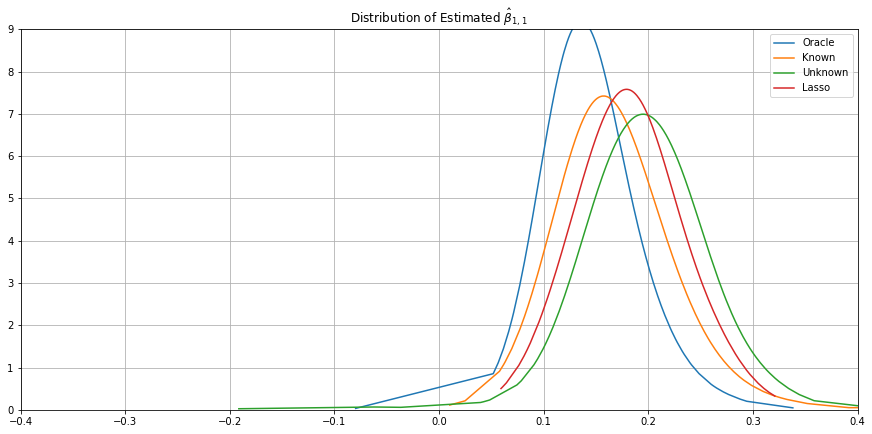

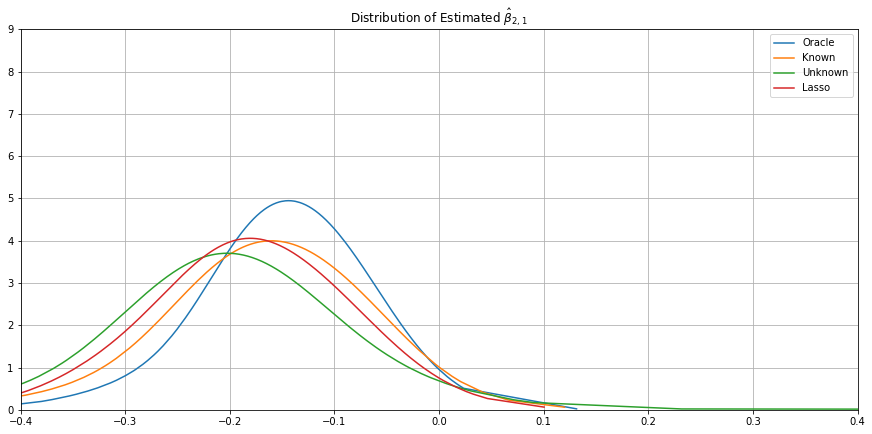

In [15]:
psd.tbl_dsp(btables[1],1,5,line_nms[1],1)
psd.coeffden(bcoeff[1],line_nms[1],[-0.4,0.4],9,2,1,0,0)
psd.coeffden(bcoeff[1],line_nms[1],[-0.4,0.4],9,2,0,0,0)

<h3> Trial Set 1.2: Comments on Primary Function Coefficient Estimates </h3>

* The results here are similar to those in 1.1 but here there is a more clear seperation between the sampling distribution of the oracle an the rest. 

<a href='#index'> Back to Index </a>
<a id='trial_13'></a>

<h2>Trial Set 1.3: Description </h2> 

Here we examine the sampling distribution of $\hat{\beta}_1, \hat{\alpha}_{1}$.

* Number of Cross Sections: 10


* Number of Endogenous Regressors: 1


* Number of Exogenous Regressors: 1


* Number of Time Periods: 50


* Total Number of Instruments: 45


* Number of Instrument Relevant to Each Cross Section: 3





<h3> Trial Set 1.3: Merged DGP and Estimator Function Input Dictionary Comparison </h3> 

Here I have merged together the dictionaries used to generate both the underlying dataset and the results (you will see the file name for this data set below) and the dictionary used to produce the estimates based on that data below. For a description of each variable name please see <a href='#var_desc'>Variable Description</a>

In [16]:
merged_dcts[2][0]

{'alph': 0.4,
 'c_H': 1.0,
 'c_inst': 3,
 'c_mvd': 1.0,
 'c_uvd': 1.0,
 'cin': 'crs',
 'cv': 0,
 'dep_nm': 'Y',
 'en_nm': ['Z1,1'],
 'epsil': 0.1,
 'err_vpro': [0.8, 0.36],
 'ex_nm': ['Z2,1'],
 'ex_vpro': [0.5],
 'frc': 0,
 'input_filename': 'pscdata_9_4_1646.json',
 'inst_vpro': [0.5, 0.25, -0.1],
 'k_H': 9,
 'k_mvd': 9,
 'k_parts': 4,
 'k_uvd': 9,
 'kwnsub': 0,
 'lasso': 0,
 'n_alphs': 20,
 'n_end': 1,
 'n_exo': 1,
 'n_parts': 4,
 'ncs': 10,
 'nds': 500,
 'ntp': 50,
 'orcl': 1,
 'r_seed': 19977,
 'sec_pan': 1,
 't_inst': 45,
 'tin': 't'}

<h3> Trial Set 1.3: True Secondary Equation Coefficients Comparison </h3> 

Here I display the coefficent vectors $\alpha_{1jd}$ used to generate the data set (by row indicating cross section and equation) corresponding to the position its file name appears in 'input_filenames0' above.

**Note:** 


1.) A zero coefficient in the following matrix means that the instrument it multiplies is not relevant to that cross section. 

2.) The density of the secondary regression coefficient matrix is **2%**


In [17]:
display_html(true_acoeffs[2][0][0])

,"$\alpha_{11,1}$","$\alpha_{12,1}$","$\alpha_{12,2}$","$\alpha_{12,3}$","$\alpha_{12,4}$","$\alpha_{12,5}$","$\alpha_{12,6}$","$\alpha_{12,7}$","$\alpha_{12,8}$","$\alpha_{12,9}$",...,"$\alpha_{12,36}$","$\alpha_{12,37}$","$\alpha_{12,38}$","$\alpha_{12,39}$","$\alpha_{12,40}$","$\alpha_{12,41}$","$\alpha_{12,42}$","$\alpha_{12,43}$","$\alpha_{12,44}$","$\alpha_{12,45}$"
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
5,-1.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0


<h3> Trial Set 1.3: Secondary Function Coefficient Estimates </h3>

Here I show characteristics of the sampling distributions of the elements of $\hat{\alpha}_{dj}$. 

In [18]:
for i in range(1,len(atables[2])):
    display(atables[2][i][0])
    display(line_nms[2][i])

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,36}$","$\hat{\alpha}_{12,37}$","$\hat{\alpha}_{12,38}$","$\hat{\alpha}_{12,39}$","$\hat{\alpha}_{12,40}$","$\hat{\alpha}_{12,41}$","$\hat{\alpha}_{12,42}$","$\hat{\alpha}_{12,43}$","$\hat{\alpha}_{12,44}$","$\hat{\alpha}_{12,45}$"
Bias,-0.001232,0.0,0.012557,0.000884,-0.001561,-0.000674,0.0,-0.002011,0.010671,0.0,...,0.0,0.0,0.0,0.0,0.001842,0.001180,0.0,0.0,0.0,0.0
Std,0.053821,0.0,0.171627,0.131172,0.170452,0.096586,0.0,0.124493,0.170002,0.0,...,0.0,0.0,0.0,0.0,0.117567,0.167508,0.0,0.0,0.0,0.0
MSE,0.002898,0.0,0.029613,0.017207,0.029056,0.009329,0.0,0.015503,0.029015,0.0,...,0.0,0.0,0.0,0.0,0.013825,0.028060,0.0,0.0,0.0,0.0


'Known'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,36}$","$\hat{\alpha}_{12,37}$","$\hat{\alpha}_{12,38}$","$\hat{\alpha}_{12,39}$","$\hat{\alpha}_{12,40}$","$\hat{\alpha}_{12,41}$","$\hat{\alpha}_{12,42}$","$\hat{\alpha}_{12,43}$","$\hat{\alpha}_{12,44}$","$\hat{\alpha}_{12,45}$"
Bias,0.124641,0.001199,0.645113,-0.575284,0.573123,0.440034,-0.153340,0.442791,0.568423,-0.044385,...,0.021061,0.020444,-0.019584,-0.046811,0.479273,0.553549,-0.036175,0.004481,0.007420,-0.006143
Std,0.079130,0.108980,0.205729,0.158908,0.206255,0.126933,0.118993,0.150547,0.197517,0.098751,...,0.097109,0.096965,0.095436,0.100643,0.139469,0.174067,0.095327,0.105771,0.100048,0.098883
MSE,0.021797,0.011878,0.458494,0.356204,0.371011,0.209742,0.037673,0.218728,0.362118,0.011722,...,0.009874,0.009820,0.009491,0.012320,0.249154,0.336716,0.010396,0.011208,0.010065,0.009816


'Lasso'

<h3> Trial Set 1.3: Comments on Secondary Function Coefficient Estimates </h3>
<ul>
    <li> Due to the shrinkage inherent in the operation of the lasso estimator the bias of the coefficients is substantial and in nearly half the cases growing. However the variances of each are shrinking as the number of time periods grows. <br>
        <br>
</ul>

<h3> Trial Set 1.3: True Primary Equations Coefficients Comparison </h3>

Here I display the coefficent vector $\beta_1$ used to generate the data set corresponding to the position its file name appears in 'input_filenames0' above.

In [19]:
true_bcoeffs[2][0]

,"$\beta_{1,1}$","$\beta_{1,2}$"
0,1,-1


<h3> Trial Set 1.3: Primary Function Coefficient Estimates </h3>

Here I show the sampling distribution of the elements of $\hat{\beta}_1$.  

,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.138519,0.140173
Std,0.041822,0.076550
MSE,0.020937,0.025508
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.163803,0.169185
Std,0.045917,0.090996
MSE,0.028940,0.036904
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.183740,0.185210
Std,0.051297,0.105882


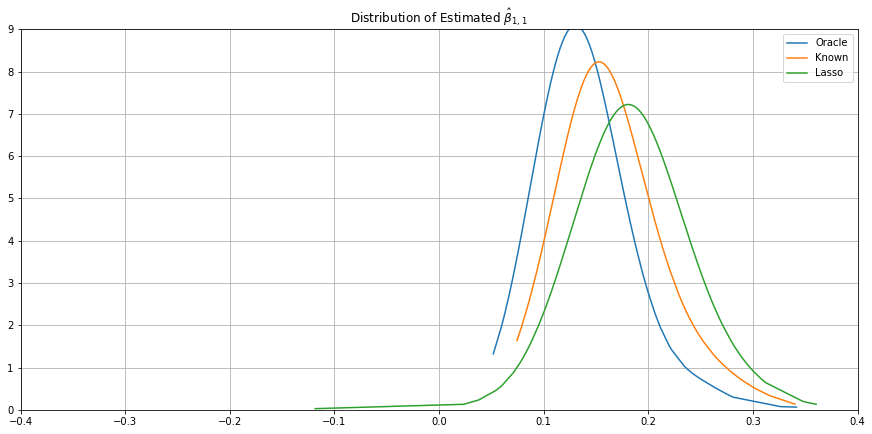

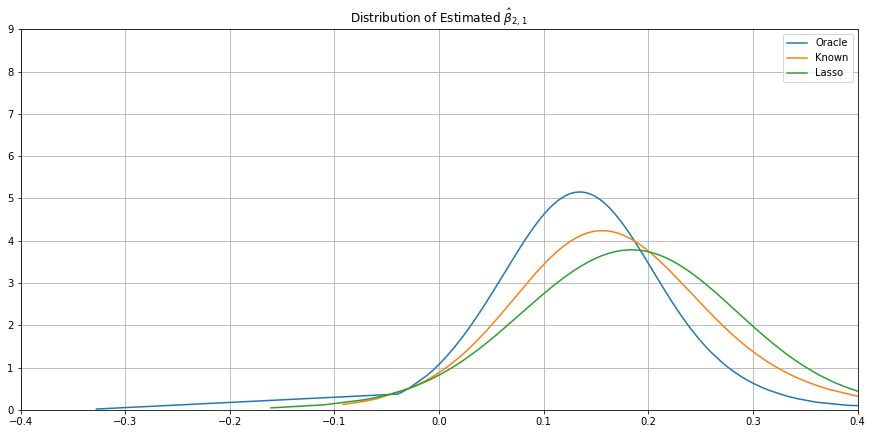

In [20]:
psd.tbl_dsp(btables[2],1,5,line_nms[2],1)
psd.coeffden(bcoeff[2],line_nms[2],[-0.4,0.4],9,2,1,0,0)
psd.coeffden(bcoeff[2],line_nms[2],[-0.4,0.4],9,2,0,0,0)

<h3> Trial Set 1.3: Comments on Primary Function Coefficient Estimates </h3>

<ul>
    <li> The behavior here is the same as the the known subset estimation in trials set 1.1
        <br><br> 
</ul>

<a href='#index'> Back to Index </a>
<a id='trial_14'></a>

<h2>Trial Set 1.4: Lasso Comparison where $t_{inst} \in \{15,30,45,100\}$ </h2> 

Here we examine the sampling distribution of $\hat{\beta}_1, \hat{\alpha}_{1}$.

* Number of Cross Sections: 10


* Number of Endogenous Regressors: 1


* Number of Exogenous Regressors: 1


* Number of time periods: 50


* Number of Instrument Relevant to Each Cross Section: 3



<h3> Trial Set 1.4: Merged DGP and Estimator Function Input Dictionary Comparison </h3> 

Here I have merged together the dictionaries used to generate both the underlying dataset and the results (you will see the file name for this data set below) and the dictionary used to produce the estimates based on that data below. 

Below you will see a slider which can be used to summarize this merged dictionary corresponding to the position its file name appears in 'input_filenames0' above. 

In accordance with the trial description, the only differences that should exist are the number of time periods (ntp) and the file name of the data set uded to generate the results.

Here I only display the dictionary for the new case where t_inst = 100

In [37]:
merged_dcts[3][3]

{'alph': 0.4,
 'c_H': 1.0,
 'c_inst': 3,
 'c_mvd': 1.0,
 'c_uvd': 1.0,
 'cin': 'crs',
 'cv': 0,
 'dep_nm': 'Y',
 'en_nm': ['Z1,1'],
 'epsil': 0.1,
 'err_vpro': [0.8, 0.36],
 'ex_nm': ['Z2,1'],
 'ex_vpro': [0.5],
 'frc': 0,
 'input_filename': 'pscdata_9_5_1068.json',
 'inst_vpro': [0.5, 0.25, -0.1],
 'k_H': 9,
 'k_mvd': 9,
 'k_parts': 4,
 'k_uvd': 9,
 'kwnsub': 0,
 'lasso': 1,
 'n_alphs': 20,
 'n_end': 1,
 'n_exo': 1,
 'n_parts': 4,
 'ncs': 10,
 'nds': 500,
 'ntp': 50,
 'orcl': 0,
 'r_seed': 19977,
 'sec_pan': 1,
 't_inst': 100,
 'tin': 't'}

<h3> Trial Set 1.4: True Secondary Equation Coefficients Comparison </h3> 

Here I display the coefficent vectors $\alpha_{1jd}$ used to generate the data set (by row indicating cross section and equation) corresponding to the position its file name appears in 'input_filenames0' above. Here they should also be identical across data sets. 

**Note:** 


1.) A zero coefficient in the following matrix means that the instrument it multiplies is not relevant to that cross section. 

2.) In accordance with the description above they should be identical across results data sets.

3.) Here I only show the parameter matrix for the new case where there are 100 total instruments

In [36]:
display_html(true_acoeffs[3][3][0])

,"$\alpha_{11,1}$","$\alpha_{12,1}$","$\alpha_{12,2}$","$\alpha_{12,3}$","$\alpha_{12,4}$","$\alpha_{12,5}$","$\alpha_{12,6}$","$\alpha_{12,7}$","$\alpha_{12,8}$","$\alpha_{12,9}$",...,"$\alpha_{12,91}$","$\alpha_{12,92}$","$\alpha_{12,93}$","$\alpha_{12,94}$","$\alpha_{12,95}$","$\alpha_{12,96}$","$\alpha_{12,97}$","$\alpha_{12,98}$","$\alpha_{12,99}$","$\alpha_{12,100}$"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> Trial Set 1.4: Secondary Function Coefficient Estimates </h3>

Here I interactively show the sampling distribution of the elements of $\hat{\alpha}_{dj}$.  

In [23]:
for i in range(1,len(atables[3])):
    display(atables[3][i][0])
    display(line_nms[3][i])

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,21}$","$\hat{\alpha}_{12,22}$","$\hat{\alpha}_{12,23}$","$\hat{\alpha}_{12,24}$","$\hat{\alpha}_{12,25}$","$\hat{\alpha}_{12,26}$","$\hat{\alpha}_{12,27}$","$\hat{\alpha}_{12,28}$","$\hat{\alpha}_{12,29}$","$\hat{\alpha}_{12,30}$"
Bias,-0.006703,-0.008311,0.774174,-0.555108,-0.012742,0.531917,0.477534,0.422525,0.431064,-0.689710,...,-0.000667,0.563147,-0.078744,0.553700,0.450432,-0.644967,-0.570113,-0.533112,-0.476856,0.046149
Std,0.118067,0.113632,0.192091,0.151288,0.131367,0.148253,0.113703,0.112409,0.135524,0.192073,...,0.110977,0.199392,0.108498,0.168895,0.126237,0.198442,0.177251,0.169420,0.136242,0.114348
MSE,0.013985,0.012981,0.636245,0.331033,0.017420,0.304914,0.240967,0.191163,0.204183,0.512592,...,0.012316,0.356891,0.017973,0.335110,0.218824,0.455362,0.356446,0.312911,0.245953,0.015205


't_inst=30'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,36}$","$\hat{\alpha}_{12,37}$","$\hat{\alpha}_{12,38}$","$\hat{\alpha}_{12,39}$","$\hat{\alpha}_{12,40}$","$\hat{\alpha}_{12,41}$","$\hat{\alpha}_{12,42}$","$\hat{\alpha}_{12,43}$","$\hat{\alpha}_{12,44}$","$\hat{\alpha}_{12,45}$"
Bias,0.124641,0.001199,0.645113,-0.575284,0.573123,0.440034,-0.153340,0.442791,0.568423,-0.044385,...,0.021061,0.020444,-0.019584,-0.046811,0.479273,0.553549,-0.036175,0.004481,0.007420,-0.006143
Std,0.079130,0.108980,0.205729,0.158908,0.206255,0.126933,0.118993,0.150547,0.197517,0.098751,...,0.097109,0.096965,0.095436,0.100643,0.139469,0.174067,0.095327,0.105771,0.100048,0.098883
MSE,0.021797,0.011878,0.458494,0.356204,0.371011,0.209742,0.037673,0.218728,0.362118,0.011722,...,0.009874,0.009820,0.009491,0.012320,0.249154,0.336716,0.010396,0.011208,0.010065,0.009816


't_inst=45'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,91}$","$\hat{\alpha}_{12,92}$","$\hat{\alpha}_{12,93}$","$\hat{\alpha}_{12,94}$","$\hat{\alpha}_{12,95}$","$\hat{\alpha}_{12,96}$","$\hat{\alpha}_{12,97}$","$\hat{\alpha}_{12,98}$","$\hat{\alpha}_{12,99}$","$\hat{\alpha}_{12,100}$"
Bias,-0.583585,-0.001348,0.007135,-0.01748,-0.033597,0.517582,-0.042006,-0.027195,0.005558,0.003827,...,0.620277,0.504137,-0.066746,0.636200,-0.612078,-0.618234,0.038657,0.035455,-0.608054,-0.598706
Std,0.037969,0.102699,0.088461,0.09484,0.102762,0.169327,0.110313,0.104878,0.088223,0.092510,...,0.207182,0.150109,0.117423,0.215938,0.215826,0.212694,0.101856,0.103704,0.209248,0.212172
MSE,0.342013,0.010549,0.007876,0.00930,0.011689,0.296562,0.013933,0.011739,0.007814,0.008573,...,0.427667,0.276687,0.018243,0.451380,0.421220,0.427452,0.011869,0.012012,0.413515,0.403466


't_inst=100'

<h3> Trial Set 1.4: Comments on Secondary Function Coefficient Estimates </h3>
<ul>
    <li> Due to the shrinkage inherent in the operation of the lasso estimator the bias of the coefficients is substantial and in nearly half the cases growing. However the variances of each are shrinking as the number of time periods grows. <br>
        <br>
</ul>

<h3> Trial Set 1.4: True Primary Equations Coefficients Comparison </h3>

Here I interactively display the coefficent vector $\beta_1$ used to generate the data set corresponding to the position its file name appears in 'input_filenames0' above. Here they should be identical. 

In [24]:
true_bcoeffs[3][0]

,"$\beta_{1,1}$","$\beta_{1,2}$"
0,1,-1


<h3> Trial Set 1.4: Primary Function Coefficient Estimates </h3>

Here I show the sampling distribution of the elements of $\hat{\beta}_1$.  

,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.173033,-0.175257
Std,0.047163,0.084188
MSE,0.032165,0.037803
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.181545,-0.181520
Std,0.046459,0.087325
MSE,0.035117,0.040575
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.183740,0.185210
Std,0.051297,0.105882


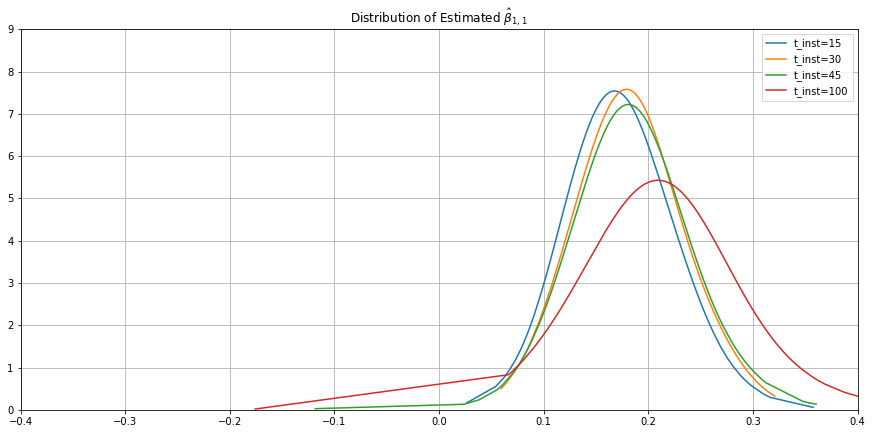

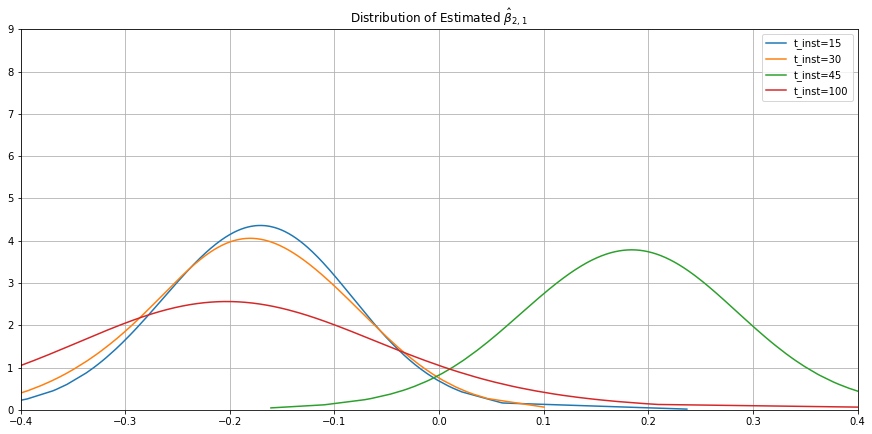

In [25]:
psd.tbl_dsp(btables[3],1,5,line_nms[3],1)
psd.coeffden(bcoeff[3],line_nms[3],[-0.4,0.4],9,2,1,0,0)
psd.coeffden(bcoeff[3],line_nms[3],[-0.4,0.4],9,2,0,0,0)

<h3> Trial Set 1.4: Comments on Primary Function Coefficient Estimates </h3>

<ul>
    <li> One can cleary see a gradual increase in the bias and  variance of both coefficients as the total number of instruments increases, this is what one would expect. 
        <br><br> 
</ul>

<a href='#index'> Back to Index </a>
<a id='trial_2'></a>

<h2>Trial Set 2.0:  Properties of Lasso Estimator, Increasing Number of Cross Sections  </h2> 

Here we examine the sampling distribution of $\hat{\beta}_1$, and $\hat{\alpha}_{1}$ as the number of cross section increases.

* Number of Cross Sections: 10,25,40


* Number of Time Periods: 50


* Number of Endogenous Regressors: 1


* Number of Exogenous Regressors: 1


* Total Number of Instruments: 100


* Number of Instrument Relevant to Each Cross Section: 3



<h3> Trial Set 2.0: Merged DGP and Estimator Function Input Dictionary Comparison </h3> 

Here I have merged together the dictionaries used to generate both the underlying dataset and the results (you will see the file name for this data set below) and the dictionary used to produce the estimates based on that data below. For a description of each variable name please see <a href='#var_desc'>Variable Description</a> 

In [26]:
merged_dcts[4][0]

{'alph': 0.4,
 'c_H': 1.0,
 'c_inst': 3,
 'c_mvd': 1.0,
 'c_uvd': 1.0,
 'cin': 'crs',
 'cv': 0,
 'dep_nm': 'Y',
 'en_nm': ['Z1,1'],
 'epsil': 0.1,
 'err_vpro': [0.8, 0.36],
 'ex_nm': ['Z2,1'],
 'ex_vpro': [0.5],
 'frc': 0,
 'input_filename': 'pscdata_9_5_1068.json',
 'inst_vpro': [0.5, 0.25, -0.1],
 'k_H': 9,
 'k_mvd': 9,
 'k_parts': 4,
 'k_uvd': 9,
 'kwnsub': 0,
 'lasso': 1,
 'n_alphs': 20,
 'n_end': 1,
 'n_exo': 1,
 'n_parts': 4,
 'ncs': 10,
 'nds': 500,
 'ntp': 50,
 'orcl': 0,
 'r_seed': 19977,
 'sec_pan': 1,
 't_inst': 100,
 'tin': 't'}

<h3> Trial Set 2.0: True Secondary Equation Coefficients Comparison </h3> 


Here I display the coefficent vectors $\alpha_{1jd}$ used to generate the data set (by row indicating cross section and equation) corresponding to the position its file name appears in 'input_filenames3' above.

**Note:** 


1.) A zero coefficient in the following matrix means that the instrument it multiplies is not relevant to that cross section. 

2.) For the sake of presentation I only show the true parameter matrix for the case where ncs = 25 

In [38]:
# psd.indict_dsp(true_acoeffs[4],2)
display_html(true_acoeffs[4][1][0])

,"$\alpha_{11,1}$","$\alpha_{12,1}$","$\alpha_{12,2}$","$\alpha_{12,3}$","$\alpha_{12,4}$","$\alpha_{12,5}$","$\alpha_{12,6}$","$\alpha_{12,7}$","$\alpha_{12,8}$","$\alpha_{12,9}$",...,"$\alpha_{12,91}$","$\alpha_{12,92}$","$\alpha_{12,93}$","$\alpha_{12,94}$","$\alpha_{12,95}$","$\alpha_{12,96}$","$\alpha_{12,97}$","$\alpha_{12,98}$","$\alpha_{12,99}$","$\alpha_{12,100}$"
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> Trial Set 2.0: Secondary Function Coefficient Estimates </h3>

Here I interactively show the sampling distribution of the elements of $\hat{\alpha}_{dj}$.  

In [28]:
for i in range(1,len(atables[4])):
    display(atables[4][i][0])
    display(line_nms[4][i])

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,91}$","$\hat{\alpha}_{12,92}$","$\hat{\alpha}_{12,93}$","$\hat{\alpha}_{12,94}$","$\hat{\alpha}_{12,95}$","$\hat{\alpha}_{12,96}$","$\hat{\alpha}_{12,97}$","$\hat{\alpha}_{12,98}$","$\hat{\alpha}_{12,99}$","$\hat{\alpha}_{12,100}$"
Bias,0.585039,0.009574,0.021597,-0.761397,0.729253,0.575302,0.703633,0.624677,-0.028229,0.002489,...,0.595770,0.581690,0.705363,0.595386,-0.777715,-0.737353,0.023410,0.020050,-0.718715,-0.734565
Std,0.023992,0.112807,0.108103,0.185935,0.155610,0.115026,0.141609,0.132426,0.109096,0.107862,...,0.112658,0.109390,0.147113,0.122463,0.164324,0.182695,0.113724,0.111751,0.171035,0.168717
MSE,0.342846,0.012817,0.012153,0.614298,0.556025,0.344203,0.515153,0.407758,0.012699,0.011640,...,0.367634,0.350329,0.519179,0.369481,0.631843,0.577067,0.013481,0.012890,0.545804,0.568051


'ncs = 25'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,91}$","$\hat{\alpha}_{12,92}$","$\hat{\alpha}_{12,93}$","$\hat{\alpha}_{12,94}$","$\hat{\alpha}_{12,95}$","$\hat{\alpha}_{12,96}$","$\hat{\alpha}_{12,97}$","$\hat{\alpha}_{12,98}$","$\hat{\alpha}_{12,99}$","$\hat{\alpha}_{12,100}$"
Bias,-0.581862,0.006492,0.011517,-0.825753,0.701385,0.650638,0.769220,0.703338,0.787019,-0.014287,...,0.635094,0.636563,0.757205,0.623385,-0.835031,-0.801682,-0.785190,0.034999,-0.789671,-0.815795
Std,0.021047,0.101059,0.105499,0.144657,0.124690,0.111617,0.129612,0.124436,0.140696,0.101418,...,0.101588,0.103905,0.117000,0.100481,0.133463,0.134487,0.145039,0.104616,0.146003,0.133618
MSE,0.339006,0.010255,0.011263,0.702794,0.507489,0.435788,0.608498,0.510169,0.639195,0.010490,...,0.413665,0.416008,0.587048,0.398705,0.715089,0.660781,0.637560,0.012169,0.644898,0.683376


'ncs = 40'

<h3> Trial Set 2.0: Comments on Secondary Function Coefficient Estimates </h3>
<ul>
    <li> Due to the lack of stability in lasso estiamtes its difficult to interpret <br>
        <br>
</ul>

<h3> Trial Set 2.0: True Primary Equations Coefficients Comparison </h3>

Here I interactively display the coefficent vector $\beta_1$ used to generate the data set corresponding to the position its file name appears in 'input_filenames3' above. Here they should be identical. 

In [29]:
true_bcoeffs[4][0]

,"$\beta_{1,1}$","$\beta_{1,2}$"
0,1,-1


<h3> Trial Set 2.0: Primary Function Coefficient Estimates </h3>

Here I show the sampling distribution of the elements of $\hat{\beta}_1$.  

,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.213261,-0.205127
Std,0.075413,0.187465
MSE,0.051168,0.077220
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.204905,0.212435
Std,0.045119,0.088168
MSE,0.044022,0.052902
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.201735,-0.208279
Std,0.039452,0.090099


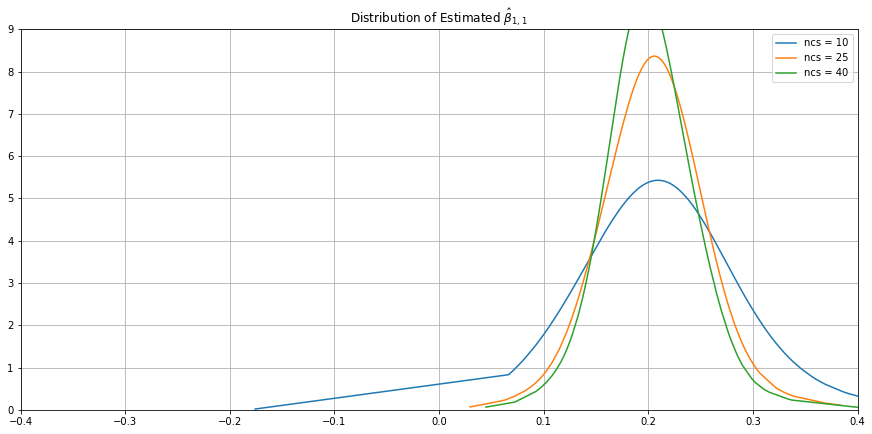

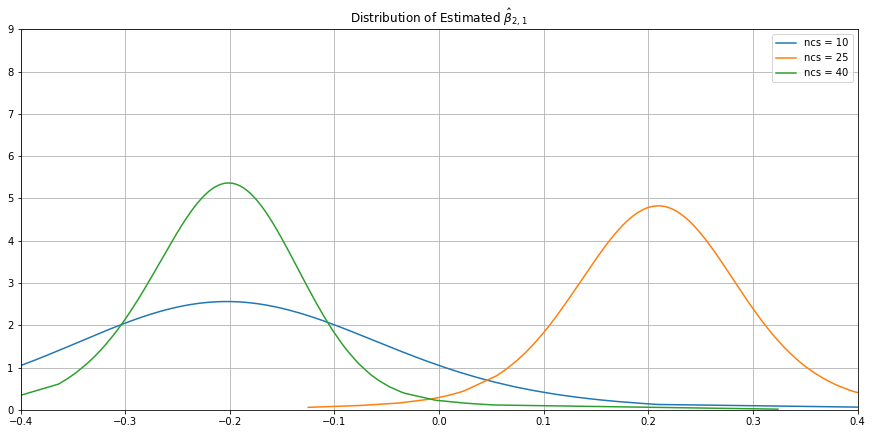

In [30]:
psd.tbl_dsp(btables[4],1,5,line_nms[4],1)
psd.coeffden(bcoeff[4],line_nms[4],[-0.4,0.4],9,2,1,0,0)
psd.coeffden(bcoeff[4],line_nms[4],[-0.4,0.4],9,2,0,0,0)

<h3> Trial Set 2.0: Comments on Primary Function Coefficient Estimates </h3>

<ul>
    <li> This is also what we would expect from a consistent estimator, a decrease in both bias an variance of the sampling distribution as the number of cross sections increases. 
        <br><br> 
</ul>

<a href='#index'> Back to Index </a>
<a id='trial_3'></a>

<h2>Trial Set 3.0: Properties of Lasso Estimator, Increasing Number of Time Periods </h2> 

Here we examine the sampling distribution of $\hat{\beta}_1, \hat{\alpha}_{1}$.

* Number of Cross Sections: 10


* Number of Time Periods: 50,100,150


* Number of Endogenous Regressors: 1


* Number of Exogenous Regressors: 1


* Total Number of Instruments: 100


* Number of Instrument Relevant to Each Cross Section: 3 



<h3> Trial Set 3.0: Merged DGP and Estimator Function Input Dictionary Comparison </h3> 

Here I have merged together the dictionaries used to generate both the underlying dataset and the results (you will see the file name for this data set below) and the dictionary used to produce the estimates based on that data below. For a description of each variable name please see <a href='#var_desc'>Variable Description</a>

In [31]:
merged_dcts[5][0]

{'alph': 0.4,
 'c_H': 1.0,
 'c_inst': 3,
 'c_mvd': 1.0,
 'c_uvd': 1.0,
 'cin': 'crs',
 'cv': 0,
 'dep_nm': 'Y',
 'en_nm': ['Z1,1'],
 'epsil': 0.1,
 'err_vpro': [0.8, 0.36],
 'ex_nm': ['Z2,1'],
 'ex_vpro': [0.5],
 'frc': 0,
 'input_filename': 'pscdata_9_5_1068.json',
 'inst_vpro': [0.5, 0.25, -0.1],
 'k_H': 9,
 'k_mvd': 9,
 'k_parts': 4,
 'k_uvd': 9,
 'kwnsub': 0,
 'lasso': 1,
 'n_alphs': 20,
 'n_end': 1,
 'n_exo': 1,
 'n_parts': 4,
 'ncs': 10,
 'nds': 500,
 'ntp': 50,
 'orcl': 0,
 'r_seed': 19977,
 'sec_pan': 1,
 't_inst': 100,
 'tin': 't'}

<h3> Trial Set 3.0: True Secondary Equation Coefficients Comparison </h3> 

Here I display the coefficent vectors $\alpha_{1jd}$ used to generate the data set (by row indicating cross section and equation) corresponding to the position its file name appears in 'input_filenames0' above.

**Note:** 


1.) A zero coefficient in the following matrix means that the instrument it multiplies is not relevant to that cross section. 





In [32]:
display_html(true_acoeffs[5][0][0])

,"$\alpha_{11,1}$","$\alpha_{12,1}$","$\alpha_{12,2}$","$\alpha_{12,3}$","$\alpha_{12,4}$","$\alpha_{12,5}$","$\alpha_{12,6}$","$\alpha_{12,7}$","$\alpha_{12,8}$","$\alpha_{12,9}$",...,"$\alpha_{12,91}$","$\alpha_{12,92}$","$\alpha_{12,93}$","$\alpha_{12,94}$","$\alpha_{12,95}$","$\alpha_{12,96}$","$\alpha_{12,97}$","$\alpha_{12,98}$","$\alpha_{12,99}$","$\alpha_{12,100}$"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> Trial Set 3.0: Secondary Function Coefficient Estimates </h3>

Here I show characteristics of the sampling distributions of the elements of $\hat{\alpha}_{dj}$, only for the new cases where ntp = 100,150


In [33]:
# display(psd.cfs_dsp(acoeff[5],atables[5],2,7,line_nms[5]))

for i in range(1,len(atables[5])):
    display(atables[5][i][0])
    display(line_nms[5][i])

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,91}$","$\hat{\alpha}_{12,92}$","$\hat{\alpha}_{12,93}$","$\hat{\alpha}_{12,94}$","$\hat{\alpha}_{12,95}$","$\hat{\alpha}_{12,96}$","$\hat{\alpha}_{12,97}$","$\hat{\alpha}_{12,98}$","$\hat{\alpha}_{12,99}$","$\hat{\alpha}_{12,100}$"
Bias,-0.165653,-0.002736,0.000518,-0.008242,-0.027379,0.334266,-0.022320,-0.006440,0.003336,0.000193,...,0.382510,0.328413,-0.030306,0.388596,-0.381809,-0.368148,0.017368,0.016637,-0.372052,-0.357027
Std,0.048930,0.046505,0.042159,0.043711,0.055918,0.109374,0.058333,0.046550,0.044191,0.042971,...,0.156547,0.103651,0.064183,0.162863,0.158995,0.161111,0.051898,0.055361,0.142074,0.160220
MSE,0.029835,0.002170,0.001778,0.001979,0.003876,0.123696,0.003901,0.002208,0.001964,0.001847,...,0.170821,0.118599,0.005038,0.177531,0.171057,0.161490,0.002995,0.003342,0.158608,0.153138


'ntp = 100'

,"$\hat{\alpha}_{11,1}$","$\hat{\alpha}_{12,1}$","$\hat{\alpha}_{12,2}$","$\hat{\alpha}_{12,3}$","$\hat{\alpha}_{12,4}$","$\hat{\alpha}_{12,5}$","$\hat{\alpha}_{12,6}$","$\hat{\alpha}_{12,7}$","$\hat{\alpha}_{12,8}$","$\hat{\alpha}_{12,9}$",...,"$\hat{\alpha}_{12,91}$","$\hat{\alpha}_{12,92}$","$\hat{\alpha}_{12,93}$","$\hat{\alpha}_{12,94}$","$\hat{\alpha}_{12,95}$","$\hat{\alpha}_{12,96}$","$\hat{\alpha}_{12,97}$","$\hat{\alpha}_{12,98}$","$\hat{\alpha}_{12,99}$","$\hat{\alpha}_{12,100}$"
Bias,-0.004609,0.000341,-0.001152,-0.003170,-0.011487,0.260881,-0.011852,-0.002758,0.001229,-0.002050,...,0.302450,0.268587,-0.019250,0.293957,-0.292451,-0.284679,0.011203,0.007885,-0.287537,-0.274214
Std,0.082776,0.025259,0.025958,0.028567,0.036559,0.082914,0.034299,0.024619,0.024727,0.024990,...,0.133631,0.088367,0.042688,0.139244,0.128469,0.121617,0.033287,0.032648,0.113861,0.127000
MSE,0.006873,0.000638,0.000675,0.000826,0.001469,0.074934,0.001317,0.000614,0.000613,0.000629,...,0.109333,0.079948,0.002193,0.105800,0.102032,0.095833,0.001234,0.001128,0.095642,0.091322


'ntp = 150'

<h3> Trial Set 3.0: Comments on Secondary Function Coefficient Estimates </h3>
<ul>
    <li> We can see and decrease in both bias and sampling variance as ntp increases. <br>
        <br>
</ul>

<h3> Trial Set 3.0: True Primary Equations Coefficients Comparison </h3>

Here I display the coefficent vector $\beta_1$ used to generate the data set corresponding to the position its file name appears in 'input_filenames4' above.

In [34]:
true_bcoeffs[5][0]

,"$\beta_{1,1}$","$\beta_{1,2}$"
0,1,-1


<h3> Trial Set 3.0: Primary Function Coefficient Estimates </h3>

Here I show the sampling distribution of the elements of $\hat{\beta}_1$.  

,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.213261,-0.205127
Std,0.075413,0.187465
MSE,0.051168,0.077220
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.172601,-0.182489
Std,0.055952,0.079299
MSE,0.032922,0.039591
,"$\hat{\beta}_{1,1}$","$\hat{\beta}_{2,1}$"
Bias,0.137235,-0.132297
Std,0.045772,0.070670


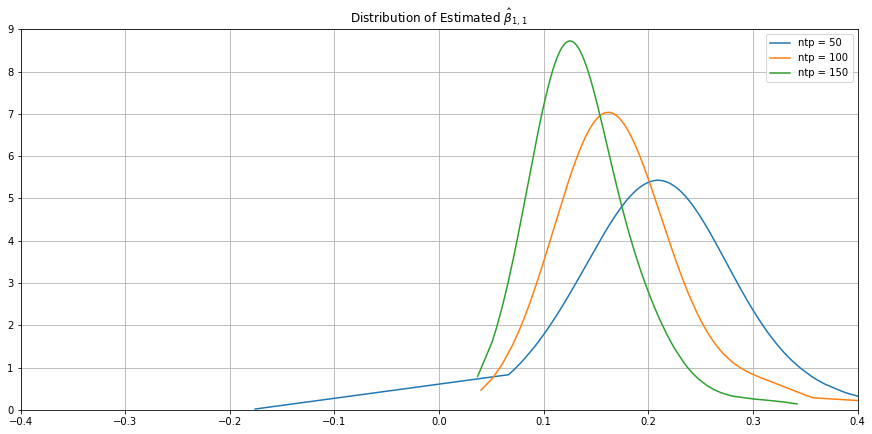

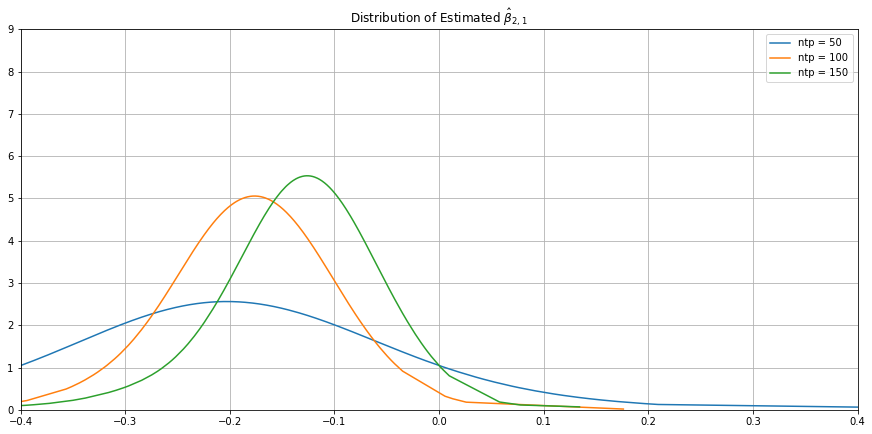

In [35]:
psd.tbl_dsp(btables[5],1,5,line_nms[5],1)
psd.coeffden(bcoeff[5],line_nms[5],[-0.4,0.4],9,2,1,0,0)
psd.coeffden(bcoeff[5],line_nms[5],[-0.4,0.4],9,2,0,0,0)

<h3> Trial Set 3.0: Comments on Primary Function Coefficient Estimates </h3>

* Precisely what we woud expect from a consistent and asymptotically normally distributed estimator. 